# Comparing sets in the Rust Standard Library
### David Rackerby

### Hypothesis
Most major programming language's claim that their official implementations of a data structur are "better than anything you could write yourself." Rust's standard containers (`std::collections`) come closer to that ideal than most languages due to their modern implementations of classical data structures. For example, in Rust 1.73, the HashSet uses SIMD for lookups and B-Trees to implement ordered sets. The HashSet–with a time of $O(1)$ amortized for all standard operations–is expected to outperform the BTreeSet, which runs in $O(lg(n))$ time for the same operations. However, it's not officially documented when BTreeSet is expected to perform better than the HashMap. Due to implementation reasons, it's expected that for small input sizes the BTreeSet will be faster due to the smaller overhead of comparisons versus hashing. We hypothesize that the range of values for which the B-Tree performs better is between 0 and 10,000 elements. Another factor to consider is the hash function: various hash functions differ in purpose and, by extension, performance. A cryptographic hash function is often more focused on security, while others focus on performance more. Here, we also compare the performance of two hash functions: SipHash 1-3 (Rust's default) and aHash, which is claimed to be the "fastest, DOS resistant hash currently available in Rust." We hypothesize that the HashSet using aHash as its hash function will perform faster than the default of SipHash 1-3, as it claims.

### Methods
The data inserted into both sets will be pseudo-randomly generated for one run and will be completely distinct on another. Insertion times will be measured until the total insertion time for either of the sets surpasses 3 seconds. The version of Rust used is Rust 1.73, compiled using the default release mode when starting a new Cargo project. The version of Python used is 3.11.2. The version of Matplotlib used is 3.7.1. The pseudo-random number generator used is the ChaCha random number generator. The notebook used to produce this report can be found at https://github.com/rikipls/CSE-431-Honors

```rust
use rand::{Rng, SeedableRng};
use rand_chacha::ChaCha8Rng;

use std::collections::{HashSet, BTreeSet, hash_map};
use std::error::Error;
use std::time::Instant;
use std::fs::File;
use std::hash::BuildHasher;
use std::io::Write;

const OUT_DIR: &str = "out";
const SEED: u64 = 431;
const NUM_ELEMENTS: usize = 30_000_000;

fn main() -> Result<(), Box<dyn Error>> {
    // Pseudorandom data
    run::<hash_map::RandomState>("sip13", true)?;
    run::<ahash::RandomState>("ahash", true)?;

    // All elements are distinct
    run::<hash_map::RandomState>("sip13", false)?;
    run::<ahash::RandomState>("ahash", false)
}

fn run<Hasher: Default + BuildHasher>(out_path: &str, random_data: bool) -> Result<(), Box<dyn Error>> {
    let mut rng = ChaCha8Rng::seed_from_u64(SEED);

    // Either use pseudorandom data or have data[i] == i for unique elements
    let data: Vec<usize> = if random_data {
        (0..NUM_ELEMENTS).map(|_| rng.gen_range(0..usize::MAX)).collect()
    } else {
        (0..NUM_ELEMENTS).collect()
    };

    // Copies
    let mut hashset_time: Vec<u128> = vec![0; NUM_ELEMENTS];
    let mut btreeset_time: Vec<u128> = vec![0; NUM_ELEMENTS];
    let mut total_hashset_time = 0.0;
    let mut total_btreeset_time = 0.0;

    let mut hash_set: HashSet<usize, Hasher> = HashSet::default();
    let mut btree_set: BTreeSet<usize> = BTreeSet::new();

    let mut num_elements_processed = NUM_ELEMENTS;

    for i in 0..NUM_ELEMENTS {
        let val = data[i];

        // hashset
        let now_hashset = Instant::now();
        hash_set.insert(val);
        let hash_elapsed = now_hashset.elapsed();
        hashset_time[i] = hash_elapsed.as_nanos();
        total_hashset_time += hash_elapsed.as_secs_f64();

        // btreeset
        let now_btreeset = Instant::now();
        btree_set.insert(val);
        let btree_elapsed = now_btreeset.elapsed();
        btreeset_time[i] = btree_elapsed.as_nanos();
        total_btreeset_time += btree_elapsed.as_secs_f64();

        // Stop after total elapsed time exceeds 3 seconds
        if total_btreeset_time >= 3.0 || total_hashset_time >= 3.0 {
            num_elements_processed = i;
            break;
        }
    }

    let nonzero_hashset_times_in_ns= &hashset_time[..num_elements_processed];
    let nonzero_btreeset_times_in_ns= &btreeset_time[..num_elements_processed];

    let hash_times_str: Vec<String> = nonzero_hashset_times_in_ns.iter().map(|n| format!("{n}")).collect();
    let tree_times_str: Vec<String> = nonzero_btreeset_times_in_ns.iter().map(|n| format!("{n}")).collect();

    let f_type = if random_data { "random" } else { "fixed"};

    let mut f_hash = File::create(format!("{OUT_DIR}/{out_path}-{f_type}-hash.txt"))?;
    let mut f_tree = File::create(format!("{OUT_DIR}/{out_path}-{f_type}-tree.txt"))?;

    writeln!(f_hash, "{}", hash_times_str.join("\n"))?;
    writeln!(f_tree, "{}", tree_times_str.join("\n"))?;

    Ok(())
}
```

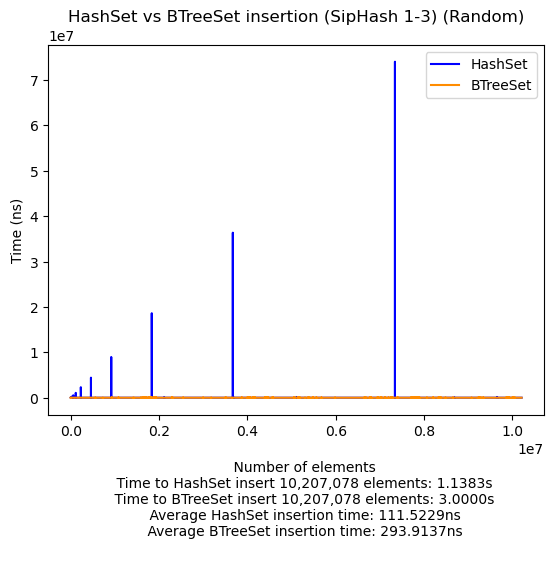

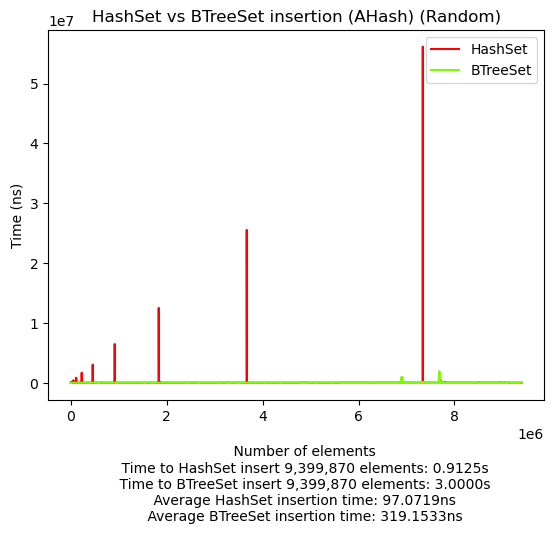

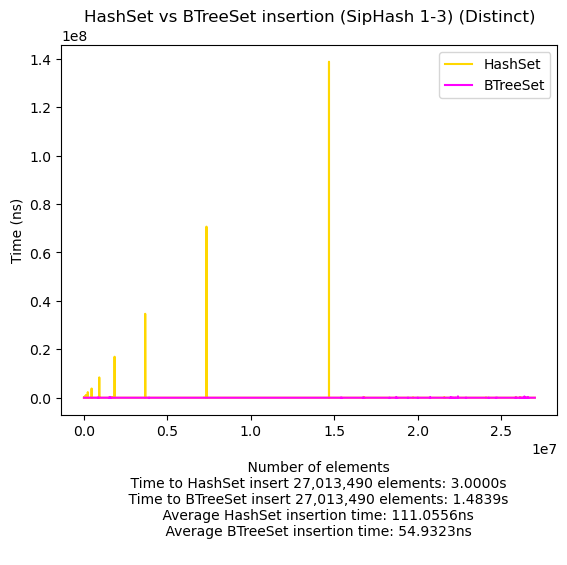

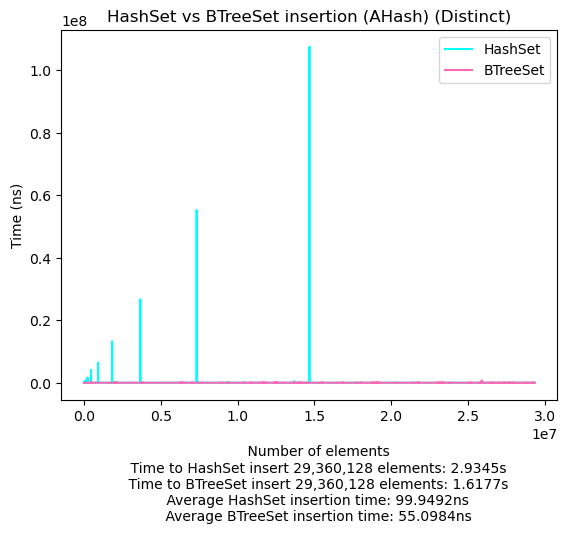

In [2]:
import matplotlib.pyplot as plt

f_hash_sip13_random = open('out/sip13-random-hash.txt', 'r')
f_btree_sip13_random = open('out/sip13-random-tree.txt', 'r')
f_hash_ahash_random = open('out/ahash-random-hash.txt', 'r')
f_btree_ahash_random = open('out/ahash-random-tree.txt', 'r')
f_hash_sip13_distinct = open('out/sip13-fixed-hash.txt', 'r')
f_btree_sip13_distinct = open('out/sip13-fixed-tree.txt', 'r')
f_hash_ahash_distinct = open('out/ahash-fixed-hash.txt', 'r')
f_btree_ahash_distinct = open('out/ahash-fixed-tree.txt', 'r')

hash_sip13_random = list(map(int, f_hash_sip13_random.readlines()))
btree_sip13_random = list(map(int, f_btree_sip13_random.readlines()))
hash_ahash_random = list(map(int, f_hash_ahash_random.readlines()))
btree_ahash_random = list(map(int, f_btree_ahash_random.readlines()))
hash_sip13_distinct = list(map(int, f_hash_sip13_distinct.readlines()))
btree_sip13_distinct = list(map(int, f_btree_sip13_distinct.readlines()))
hash_ahash_distinct = list(map(int, f_hash_ahash_distinct.readlines()))
btree_ahash_distinct = list(map(int, f_btree_ahash_distinct.readlines()))

colors = ['blue', 'red', 'gold', 'cyan', 'darkorange', 'lawngreen', 'magenta', 'hotpink']

def plot_compare(hash_insertion_times: list, btree_insertion_times: list, figure_id: int, title: str):
    total_hash_insertion_time = sum(hash_insertion_times)
    total_btree_insertion_time = sum(btree_insertion_times)
    plt.figure(figure_id)
    plt.plot(hash_insertion_times, colors[figure_id], label='HashSet')
    plt.plot(btree_insertion_times, colors[figure_id+4], label='BTreeSet')
    xlabel = f'''
    Number of elements
    Time to HashSet insert {len(hash_insertion_times):,} elements: {(total_hash_insertion_time * 1e-9):.4f}s
    Time to BTreeSet insert {len(btree_insertion_times):,} elements: {(total_btree_insertion_time * 1e-9):.4f}s
    Average HashSet insertion time: {(total_hash_insertion_time / len(hash_insertion_times)):.4f}ns
    Average BTreeSet insertion time: {(total_btree_insertion_time / (len(btree_insertion_times))):.4f}ns
    '''
    plt.xlabel(xlabel)
    plt.ylabel("Time (ns)")
    plt.legend()
    plt.title(f"HashSet vs BTreeSet insertion {title}")
    plt.show()

times = [(hash_sip13_random, btree_sip13_random), (hash_ahash_random, btree_ahash_random), (hash_sip13_distinct, btree_sip13_distinct), (hash_ahash_distinct, btree_ahash_distinct)]
titles = ['(SipHash 1-3) (Random)', '(AHash) (Random)', '(SipHash 1-3) (Distinct)', '(AHash) (Distinct)']
for i, times_pair, title in zip(range(4), times, titles):
    plot_compare(times_pair[0], times_pair[1], i, title)

plt.show()

f_hash_sip13_random.close()
f_btree_sip13_random.close()
f_hash_ahash_random.close()
f_btree_ahash_random.close()
f_hash_sip13_distinct.close()
f_btree_sip13_distinct.close()
f_hash_ahash_distinct.close()
f_btree_ahash_distinct.close()

### Results
There are two variables: hash function and data distribution. We utilize two different hash functions: SipHash 1-3 and aHash. We randomly generate a sequence over the range $[n] = \{0, \dots, n-1\}$ where $n = 30,000,000$. For figures labeled **Random**, the randomly-generated sequence is used. For figures labeled **Distinct**, the ordered set $[n]$ is used. Figures labeled **SipHash** use SipHash 1-3 as the hash function in the HashSet. Figures labeled **AHash** use aHash in the HashSet. Observe that when $[n]$ is used, all elements are distinct and inserted in increasing order, while the other two test runs insert data that is randomly sampled with possible duplicates. Since duplicates are possible, this affects the performance of the insertion operation within both data structures.

### Discussion
Across both types of data, aHash performs faster than SipHash 1-3 as expected. In all charts, the massive spikes seen are likely from when the HashSet must reallocate its internal buffer, which is $O(n)$. Since the size is doubled each time, so do the insertion times at the spikes. What's unexpected is the dramatic performance difference exhibited when the inserted data is distinct and in increasing order. In this case, the BTreeSet performs better on average, despite needing to search for a new insertion location every time. Additionally, since the data is inserted in increasing order, the BTreeSet must also occasionally rebalance itself. One possible explanation of the better performance is caching and unique elements. Since the HashSet must always insert unique elements, there will be more collisions. Once one occurs, the program must continue searching within the hashtable. Due to the table's quadratic probing, more collisions cause indexes into the table to jump around, which is worse for caching. Compare this to the BTreeSet: although it must still walk some pointers (as expected of a tree structure), once the array the value belongs to has been found, the linear search inside of that array is fast. This is because that array is already in the cache due to being previously accessed in prior insertions. With regards to the original hypothesis, it appears that it is not the case that after 10,000 elements the HashMap performs much better. What's instead observed as that even as the number of elements gets very large, the BTReeMap performs quickly, although still slower than the HashMap on average (barring the standout example above).

### Conclusions
On both types of data, aHash performed better on average than SipHash 1-3. This was expected, but aHash does come with the caveat that it's only suitable for in-memory hashmaps (hashsets). However, when the data was inserted in sorted order, the BTreeSet exhibited much better average performance in comparison to the HashSet regardless of the hash function used. This exemplified the effect of caching and insertion order on the performance of data structures.